In [1]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from cipred.lu2019 import lu_fit, lu_pred_prime
from sklearn import metrics

import matplotlib.pyplot as plt

C:\Users\jml\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

Dataset providing hourly $NO_2$ measured by reference air quality stations from 2015 to 2022 in Oslo, Norway.

These datasets are embedded in this example. 

You can access these historical data at https://luftkvalitet.nilu.no/en/historical.

They have been quality controled by experts. Non-valid data have been removed. 

<u> As said on this website </u>: "Data for the current year are preliminary. Data for each calendar year must be quality assured by 1st July of the following year. Until then, there may be changes in the data due to quality control measures."

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
data_dir = os.path.join(parent_dir,"data")

In [3]:
# read data

In [4]:
a = pd.read_csv(os.path.join(data_dir,'2015-2016.csv'),skiprows=3)
b = pd.read_csv(os.path.join(data_dir,'2017-2018.csv'),skiprows=3)
c = pd.read_csv(os.path.join(data_dir,'2019-2020.csv'),skiprows=3)
d = pd.read_csv(os.path.join(data_dir,'2021-2022.csv'),skiprows=3)

In [5]:
a.columns = b.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'smestad', 'smestad%', 
              'åkebergveien','åkebergveien%']
a = a.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
b = b.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
c.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'åkebergveien','åkebergveien%']
c = c.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','åkebergveien','åkebergveien%'])
d.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%']

d = d.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%'])

In [6]:
df = pd.concat((a,b,c,d),axis=0)

In [7]:
df = df.dropna(how='any', axis=0)

In [8]:
target = ['kirkeveien']
predictors = ['bygdøyAlle','hjortnes','alnabru','manglerud','akersykehus'] # 504

In [9]:
# only positive values
for cols in target+predictors:
    df = df[df[cols] > 0]

In [10]:
df["datetime"] = pd.to_datetime(df["datetime"],format="%d.%m.%Y %H:%M")

In [11]:
df

,datetime,alnabru,bygdøyAlle,hjortnes,kirkeveien,manglerud,akersykehus
1,2015-01-01 01:00:00,39.005673,53.847075,48.489794,54.174284,59.428821,39.302824
2,2015-01-01 02:00:00,45.409935,60.015759,49.151176,67.502740,86.859630,52.796860
3,2015-01-01 03:00:00,41.609032,51.463153,56.762501,62.589420,106.553432,52.929326
4,2015-01-01 04:00:00,42.059002,56.232895,43.273618,70.242064,78.570300,29.593088
5,2015-01-01 05:00:00,42.589462,47.527457,44.436780,67.106365,61.429350,25.146724
...,...,...,...,...,...,...,...
17383,2022-12-26 07:00:00,21.700010,24.241915,26.911733,21.557100,14.766185,18.636792
17384,2022-12-26 08:00:00,12.679270,24.269225,30.283357,26.087208,7.536846,15.601832
17385,2022-12-26 09:00:00,21.818050,22.386398,28.942285,25.048695,6.926513,10.625931
17386,2022-12-26 10:00:00,11.082022,20.937849,30.791482,14.009510,5.911969,10.675534


In [12]:
# Training/Test period 2015-2021
train_test = df.loc[df['datetime']<'2022-01-01 00:00',:] 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_test[predictors], train_test[target], test_size=0.2, random_state=42)

# Train/Test

In [14]:
## model
# Number of variables to possibly split at in each node: rounded down square root of the number variables. 
min_samples_split= np.floor(np.sqrt(len(predictors))).astype(np.int64)

# Minimal node size. Default 1 for classification, 5 for regression, 3 for survival,
min_samples_leaf=5

In [15]:
rf_reg = RandomForestRegressor(n_estimators = 500, 
                               min_samples_split= min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               #max_depth=4,
                               #random_state=0,
                               n_jobs=10) 

In [16]:
rf_reg, train_oob_error = lu_fit(rf_reg, X_train, np.ravel(y_train))

In [17]:
pred_test = lu_pred_prime(rf_reg,train_oob_error,X_test,y_test,0.05)

In [18]:
pred_test

,pred,obs,N0.025,N0.975,p-value
id,,,,,
0,7.182495,8.182084,3.285054,10.002696,0.713171
1,10.198709,10.228155,4.294702,14.363436,0.461640
2,47.996418,55.025098,35.712435,63.387658,0.854146
3,2.449481,2.811408,1.037920,3.941880,0.637587
4,28.613218,34.236400,17.921902,42.730593,0.779081
...,...,...,...,...,...
8795,63.961805,70.153588,49.804987,90.012522,0.822387
8796,6.261984,5.726011,3.837846,9.021091,0.278673
8797,32.705609,41.754696,20.072020,44.856728,0.904084


In [19]:
# bias
np.mean((pred_test['obs']-pred_test['pred']).values)

0.05114659954220542

In [20]:
# MAE
np.mean(np.abs(pred_test['obs']-pred_test['pred']).values)

5.897661564783706

In [21]:
# variance
def variance(target, pred):
        bias = np.mean(pred-target)
        res = np.mean(np.abs(pred - target - bias))**2
        return res

variance(pred_test['obs'].values,pred_test['pred'].values)

34.81935276394026

In [22]:
metrics.r2_score(pred_test['obs'],pred_test['pred'])

0.8359646786452214

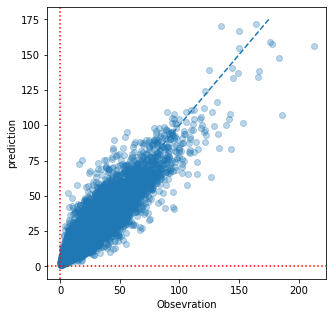

In [23]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(pred_test['obs'].values, pred_test['pred'].values, alpha=0.3)
axs.plot([0,175], [0,175], "--", label="Perfect model")
axs.set(xlabel="Obsevration",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [24]:
pred_test = pred_test.sort_values('p-value')
pred_test['U'] = np.linspace(0.,1.,pred_test.shape[0])

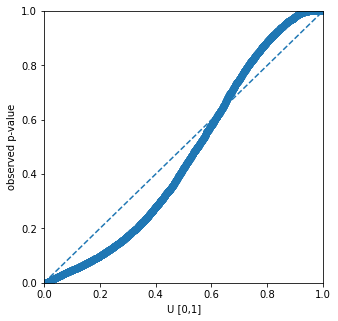

In [25]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(pred_test['U'].values, pred_test['p-value'].values, alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Validation

In [26]:
validation = df.loc[df['datetime']>='2022-01-01 00:00',:]

In [27]:
validation = validation.reset_index()
X_validation = validation[predictors]
y_validation = validation[target]

In [28]:
tmp_validation = lu_pred_prime(rf_reg,train_oob_error,X_validation,y_validation,0.05)

In [29]:
# bias
np.mean((tmp_validation['obs']-tmp_validation['pred']).values)

-0.05901625655342406

In [30]:
# MAE
np.mean(np.abs(tmp_validation['obs']-tmp_validation['pred']).values)

4.445008624747126

In [31]:
# variance
def variance(target, pred):
        bias = np.mean(pred-target)
        res = np.mean(np.abs(pred - target - bias))**2
        return res

variance(pred_test['obs'].values,pred_test['pred'].values)

34.81935276394026

In [32]:
metrics.r2_score(tmp_validation['obs'],tmp_validation['pred'])

0.7955918823069017

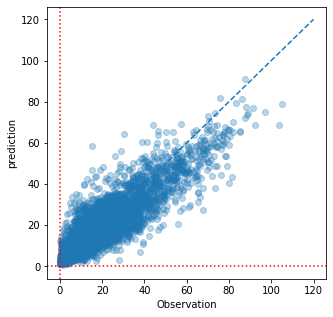

In [33]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(tmp_validation['obs'].values, tmp_validation['pred'].values, alpha=0.3)
axs.plot([0,120], [0,120], "--", label="Perfect model")
#axs.set(xlim=(0,30),ylim=(0,30),xlabel="Ref",ylabel="prediction")
axs.set(xlabel="Observation",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [34]:
tmp_validation = tmp_validation.sort_values('p-value')
tmp_validation['U'] = np.linspace(0.,1.,tmp_validation.shape[0])

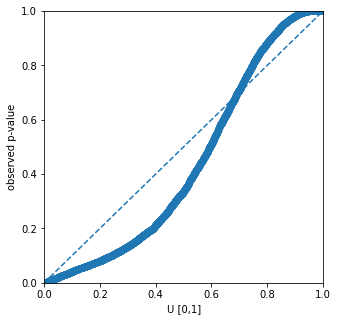

In [35]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(tmp_validation['U'].values, tmp_validation['p-value'].values, alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Illustration

In [36]:
e = pd.read_csv(os.path.join(data_dir,'20161203-20161209_original.csv'),skiprows=3)

In [37]:
e = e.drop(columns=['Til-tid','QA','QC','QA.1','QC.1','QA.2','QC.2','QA.3','QC.3','QA.4','QC.4','QA.5','QC.5'])
e.columns = ['datetime',
              'alnabru', 
              'bygdøyAlle',
              'hjortnes',
              'kirkeveien',
              'manglerud',
              'akersykehus']

In [38]:
e["datetime"] = pd.to_datetime(e["datetime"],format="%d.%m.%Y %H:%M")

In [39]:
e = e.dropna(how='any', axis=0)

In [40]:
# between 4 December 2016 and 8 December 2016
X_illustration = e[predictors]
y_illustration = e[target]

In [41]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration,y_illustration,0.05)

In [42]:
tmp_illustration['datetime'] = e['datetime']
tmp_illustration['datetime'] = pd.to_datetime(tmp_illustration["datetime"])

In [43]:
tmp_illustration = tmp_illustration.set_index('datetime')

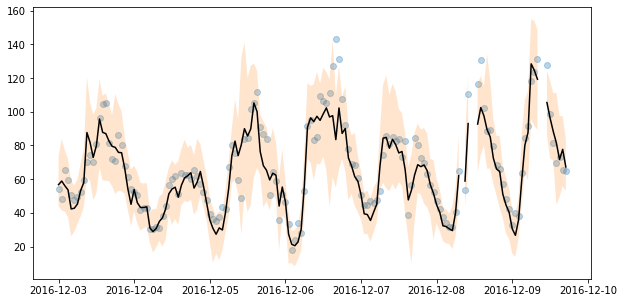

In [44]:
# Non-valid data are seen as missing values. No prediction and uncertainty is thus avalible for these values
fig, axs = plt.subplots(figsize=(10, 5))

axs.scatter(tmp_illustration.index, tmp_illustration['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration.index, tmp_illustration['N0.025'], tmp_illustration['N0.975'], alpha=0.2)
axs.plot(tmp_illustration.index, 'pred', data=tmp_illustration, color='black')
plt.show()

# Illustration 2

In [370]:
e = pd.read_csv(os.path.join(data_dir,'2022_original.csv'),skiprows=3)

In [371]:
e = e.drop(columns=['Til-tid','QA','QC','QA.1','QC.1','QA.2','QC.2','QA.3','QC.3','QA.4','QC.4','QA.5','QC.5'])
e.columns = ['datetime',
              'alnabru', 
              'bygdøyAlle',
              'hjortnes',
              'kirkeveien',
              'manglerud',
              'akersykehus']

In [372]:
e["datetime"] = pd.to_datetime(e["datetime"],format="%d.%m.%Y %H:%M")

In [373]:
e = e.dropna(how='any', axis=0)

In [383]:
X_illustration = e[predictors]
y_illustration = e[target]

In [384]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration,y_illustration,0.05)

In [385]:
tmp_illustration['datetime'] = e['datetime']
tmp_illustration['datetime'] = pd.to_datetime(tmp_illustration["datetime"])

In [386]:
tmp_illustration[tmp_illustration['obs']>100] 

,pred,obs,N0.025,N0.975,p-value,datetime
id,,,,,,
788,69.890519,103.9,52.698568,89.588332,0.998652,2022-02-02 20:00:00
789,79.343738,105.3,57.454562,101.430495,0.989232,2022-02-02 21:00:00


In [390]:
id_il = 788
tmp_illustration_tiny = tmp_illustration.iloc[id_il-3*24:id_il+3*24,:]

In [391]:
tmp_illustration_tiny = tmp_illustration_tiny.set_index('datetime')

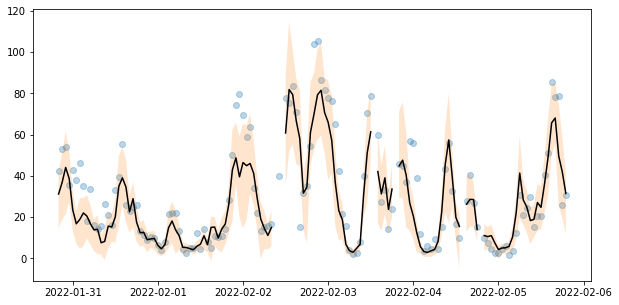

In [392]:
# Non-valid data are seen as missing values. No prediction and uncertainty is thus avalible for these values
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(tmp_illustration_tiny.index, 'pred', data=tmp_illustration_tiny, color='black')
axs.scatter(tmp_illustration_tiny.index, tmp_illustration_tiny['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration_tiny.index, tmp_illustration_tiny['N0.025'], tmp_illustration_tiny['N0.975'], alpha=0.2)
plt.show()